Import Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    classification_report, roc_curve, auc
)

from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings("ignore")


Load Dataset (fraudtrain.csv)

In [2]:
df = pd.read_csv("fraudtrain.csv")
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


Dataset Overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

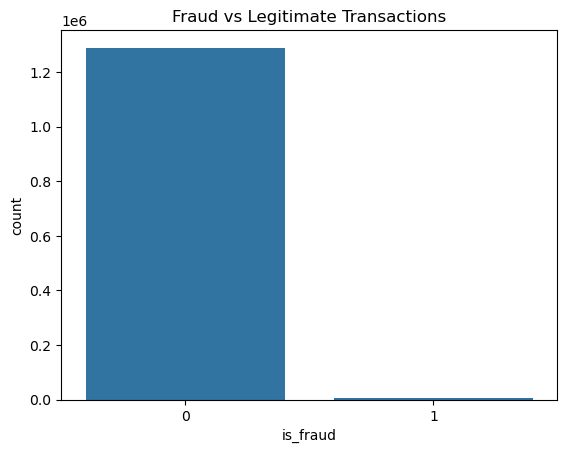

In [3]:
df.info()
df["is_fraud"].value_counts()

sns.countplot(x="is_fraud", data=df)
plt.title("Fraud vs Legitimate Transactions")
plt.show()


In [ ]:
Data Preprocessing

In [4]:
# Drop unnecessary columns
drop_cols = [
    "trans_date_trans_time", "unix_time",
    "first", "last", "street",
    "city", "state", "dob"
]
df.drop(columns=drop_cols, inplace=True, errors="ignore")
# Encode categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    df[col] = df[col].astype("category").cat.codes
# Features & target
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Handle Class Imbalance

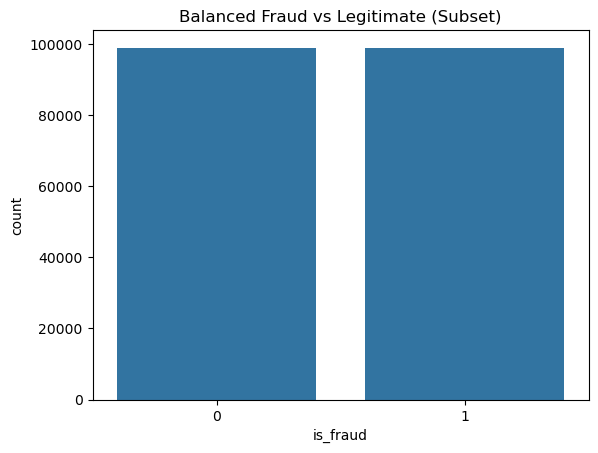

In [7]:
from imblearn.over_sampling import SMOTE
X_fast = X_scaled[:100000]
y_fast = y[:100000]

smt = SMOTE(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_fast, y_fast)

sns.countplot(x=y_resampled)
plt.title("Balanced Fraud vs Legitimate (Subset)")
plt.show()


Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2, random_state=42, stratify=y_resampled
)

Train Models

Logistic Regression

In [11]:
lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

Decision Tree

In [13]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)


Random Forest (Best)

In [15]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)


Accuracy Comparison

In [16]:
models = {
    "Logistic Regression": lr_pred,
    "Decision Tree": dt_pred,
    "Random Forest": rf_pred
}

for name, pred in models.items():
    acc = accuracy_score(y_test, pred)
    print(f"{name} Accuracy: {acc*100:.2f}%")


Logistic Regression Accuracy: 85.30%
Decision Tree Accuracy: 96.24%
Random Forest Accuracy: 96.29%


Confusion Matrix (Random Forest)

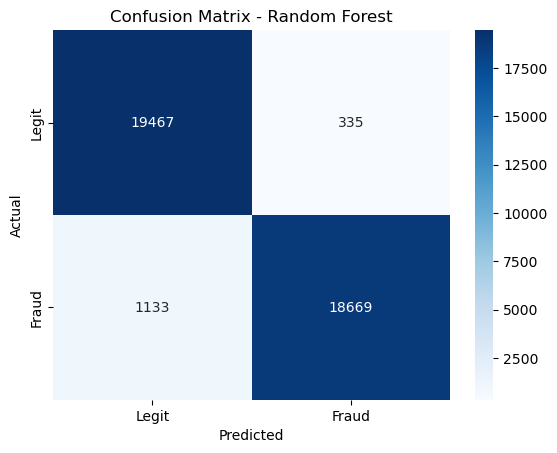

In [17]:
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legit","Fraud"],
            yticklabels=["Legit","Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


Classification Report

In [18]:
print(classification_report(y_test, rf_pred))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96     19802
           1       0.98      0.94      0.96     19802

    accuracy                           0.96     39604
   macro avg       0.96      0.96      0.96     39604
weighted avg       0.96      0.96      0.96     39604



ROC Curve

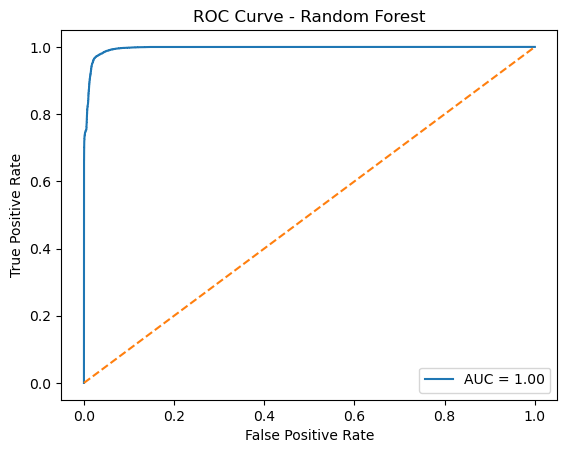

In [19]:
rf_probs = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


Predict on fraudtest.csv

In [21]:
test_df = pd.read_csv("fraudtest.csv")

test_df.drop(columns=drop_cols, inplace=True, errors="ignore")

cat_cols_test = test_df.select_dtypes(include=["object"]).columns
for col in cat_cols_test:
    test_df[col] = test_df[col].astype("category").cat.codes
feature_cols = X.columns
X_test = test_df[feature_cols]
X_test_final = scaler.transform(X_test)
test_df["is_fraud_predicted"] = rf.predict(X_test_final)

test_df.head()


,Unnamed: 0,cc_num,merchant,category,amt,gender,zip,lat,long,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,is_fraud_predicted
0,0,2291163933867244,319,10,2.86,1,29209,33.9659,-80.9355,333497,275,98699,33.986391,-81.200714,0,0
1,1,3573030041201292,591,10,29.84,0,84002,40.3207,-110.4360,302,392,108785,39.450498,-109.960431,0,0
2,2,3598215285024754,611,5,41.28,0,11710,40.6729,-73.5365,34496,259,433979,40.495810,-74.196111,0,0
3,3,3591919803438423,222,9,60.05,1,32780,28.5697,-80.8191,54767,407,71993,28.812398,-80.883061,0,0
4,4,3526826139003047,292,13,3.19,1,49632,44.2529,-85.0170,1126,196,190585,44.959148,-85.884734,0,0


Fraud Prediction Visualization

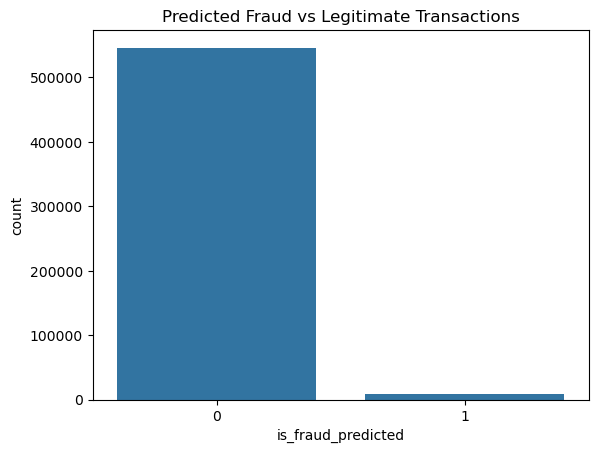

In [22]:
sns.countplot(x="is_fraud_predicted", data=test_df)
plt.title("Predicted Fraud vs Legitimate Transactions")
plt.show()


Save Predictions

In [23]:
test_df.to_csv("fraud_predictions.csv", index=False)
print("Predictions saved successfully!")


Predictions saved successfully!
